In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 3.9MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 204kB 18.2MB/s 
     |████████████████████████████████| 1.2MB 21.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
Mounted at /content/gdrive


In [2]:
!pip install kaggle --upgrade --force

     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 153kB 5.7MB/s 
     |████████████████████████████████| 235kB 36.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 143kB 41.6MB/s 
     |████████████████████████████████| 184kB 41.4MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=2753959d7a39068df8ba1c3c135abab67124430def3e0d3c38d29c80d0bee133
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
ERROR: tensorflow 2.5.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERRO

In [3]:
#hide
from fastbook import *
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/Colab Notebooks'
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modeling Deep Dive

## Categorical Embeddings

## Beyond Deep Learning

## The Dataset

### Kaggle Competitions

In [4]:
creds = ''

In [5]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
path = Path('.')
path

Path('.')

In [7]:
#hide
Path.BASE_PATH = path

In [8]:
path

Path('.')

In [9]:
! kaggle competitions download -c bluebook-for-bulldozers

 68% 33.0M/48.4M [00:00<00:00, 34.2MB/s]
100% 48.4M/48.4M [00:00<00:00, 53.5MB/s]


In [10]:
! unzip bluebook-for-bulldozers.zip

Archive:  bluebook-for-bulldozers.zip
  inflating: Data Dictionary.xlsx    
  inflating: Machine_Appendix.csv    
  inflating: Test.csv                
  inflating: Train.7z                
  inflating: Train.zip               
  inflating: TrainAndValid.7z        
  inflating: TrainAndValid.csv       
  inflating: TrainAndValid.zip       
  inflating: Valid.7z                
  inflating: Valid.csv               
  inflating: Valid.zip               
  inflating: ValidSolution.csv       
  inflating: median_benchmark.csv    
  inflating: random_forest_benchmark_test.csv  


In [11]:
path.ls(file_type='text')

(#7) [Path('median_benchmark.csv'),Path('ValidSolution.csv'),Path('TrainAndValid.csv'),Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('Machine_Appendix.csv'),Path('Test.csv')]

### Look at the Data

In [12]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [13]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [14]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [15]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [16]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [17]:
dep_var = 'SalePrice'

In [18]:
df[dep_var] = np.log(df[dep_var])

## Decision Trees

### Handling Dates

In [19]:
df = add_datepart(df, 'saledate')

In [20]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [21]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Using TabularPandas and TabularProc

In [22]:
procs = [Categorify, FillMissing]

In [23]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [24]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [25]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [26]:
len(to.train),len(to.valid)

(404710, 7988)

In [27]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [28]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [29]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [30]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [31]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [32]:
save_pickle(path/'to.pkl',to)

In [33]:
b = load_pickle(path/'to.pkl')

In [34]:
type(path/'to.pkl')

pathlib.PosixPath

In [47]:
f = open((path/'to.pkl'), 'rb')

In [48]:
pickle.load(f)

        SalesID  SalePrice  MachineID  ModelID  ...  saleIs_year_start  \
0       1139246  11.097410     999089     3157  ...                  1   
1       1139248  10.950807     117657       77  ...                  1   
2       1139249   9.210340     434808     7009  ...                  1   
3       1139251  10.558414    1026470      332  ...                  1   
4       1139253   9.305651    1057373    17311  ...                  1   
...         ...        ...        ...      ...  ...                ...   
401120  6333336   9.259130    1840702    21439  ...                  1   
401121  6333337   9.305651    1830472    21439  ...                  1   
401122  6333338   9.350102    1887659    21439  ...                  1   
401123  6333341   9.104980    1903570    21435  ...                  1   
401124  6333342   8.955448    1926965    21435  ...                  1   

         saleElapsed  auctioneerID_na  MachineHoursCurrentMeter_na  
0       1.163635e+09                1     

### Creating the Decision Tree

In [49]:
#hide
to = load_pickle(path/'to.pkl')

In [50]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [51]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

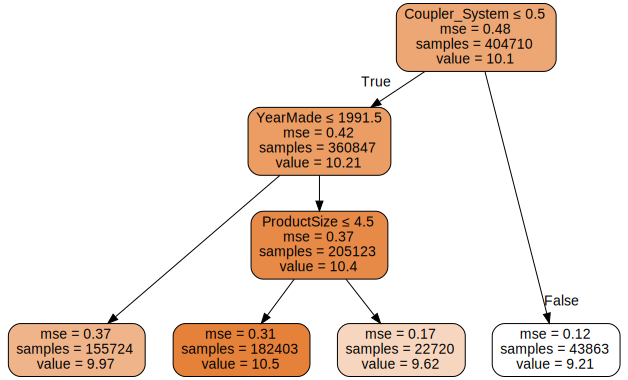

In [52]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

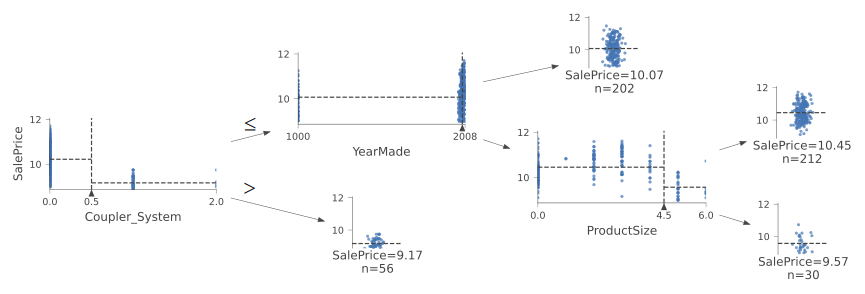

In [53]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [54]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

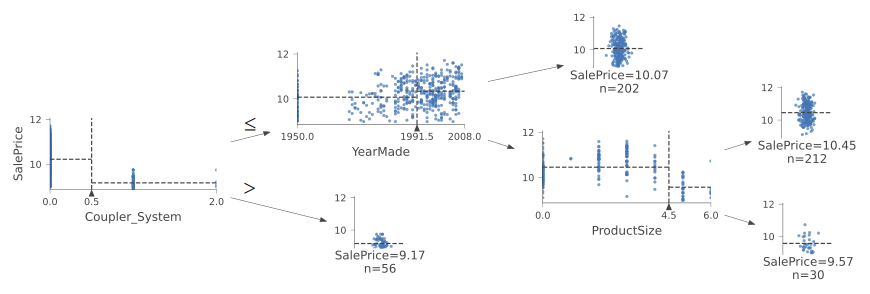

In [55]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [56]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [57]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [58]:
m_rmse(m, xs, y)

1e-06

In [59]:
m_rmse(m, valid_xs, valid_y)

0.332913

In [60]:
m.get_n_leaves(), len(xs)

(324528, 404710)

In [61]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323339)

In [62]:
m.get_n_leaves()

12397

### Categorical Variables

## Random Forests

In [63]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

In [64]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [65]:
m = rf(xs, y);

In [66]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170966, 0.232699)

In [67]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [68]:
r_mse(preds.mean(0), valid_y)

0.232699

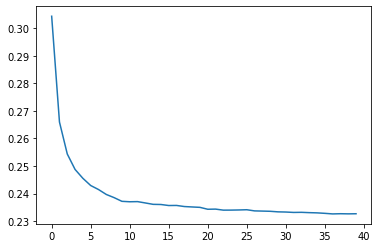

In [69]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

In [70]:
r_mse(m.oob_prediction_, y)

0.210776

## Model Interpretation

### Tree Variance for Prediction Confidence

In [71]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [72]:
preds.shape

(40, 7988)

In [73]:
preds_std = preds.std(0)

In [74]:
preds_std[:5]

array([0.26069358, 0.10409366, 0.09904178, 0.27184634, 0.13110276])

### Feature Importance

In [75]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [76]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.173023
6,ProductSize,0.117253
30,Coupler_System,0.117053
7,fiProductClassDesc,0.073112
54,ModelID,0.054777
65,saleElapsed,0.048835
3,fiSecondaryDesc,0.046104
31,Grouser_Tracks,0.041196
12,Enclosure,0.040495
32,Hydraulics_Flow,0.032725


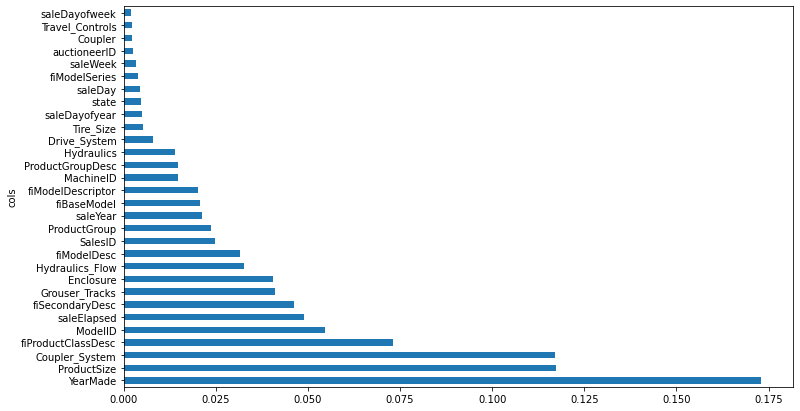

In [77]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

In [78]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [79]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [80]:
m = rf(xs_imp, y)

In [81]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18131, 0.230503)

In [82]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

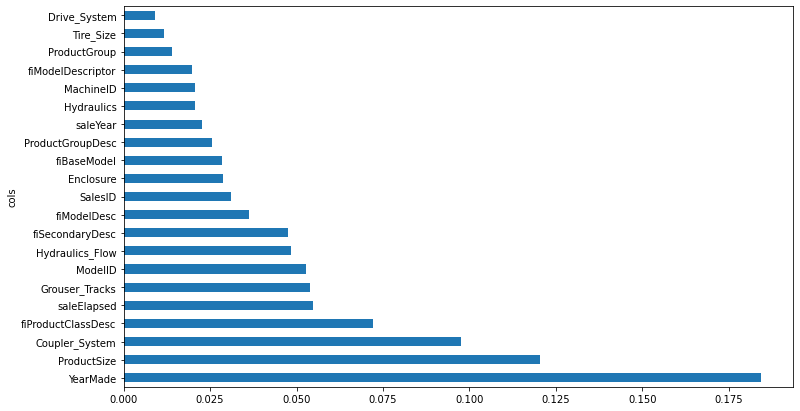

In [83]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

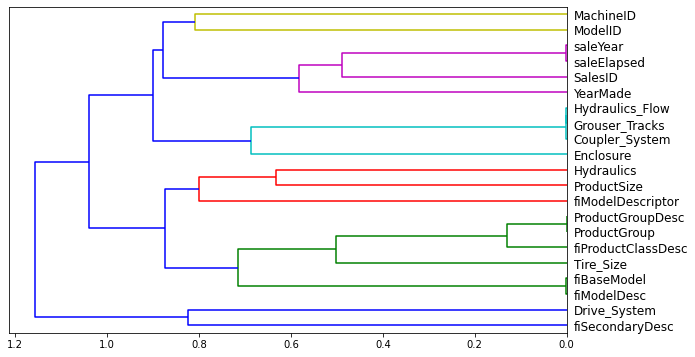

In [84]:
cluster_columns(xs_imp)

In [85]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [86]:
get_oob(xs_imp)

0.8781576734893485

In [87]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8770165273393064,
 'Grouser_Tracks': 0.8775565092698138,
 'Hydraulics_Flow': 0.8774995916903535,
 'ProductGroup': 0.8778594920344923,
 'ProductGroupDesc': 0.8770087512874477,
 'fiBaseModel': 0.8761168180455399,
 'fiModelDesc': 0.8754781084425128,
 'saleElapsed': 0.8722097904682757,
 'saleYear': 0.8768628311464004}

In [88]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8750482697068109

In [89]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [90]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [91]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [92]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183251, 0.232259)

### Partial Dependence

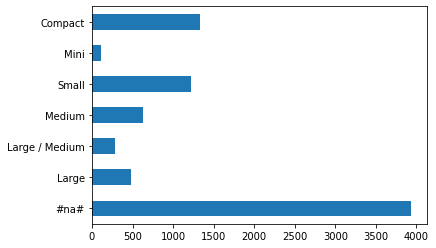

In [93]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

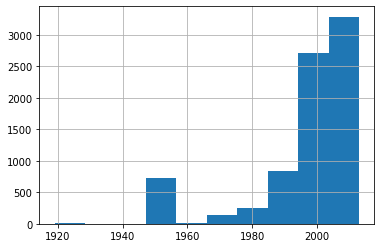

In [94]:
ax = valid_xs_final['YearMade'].hist()

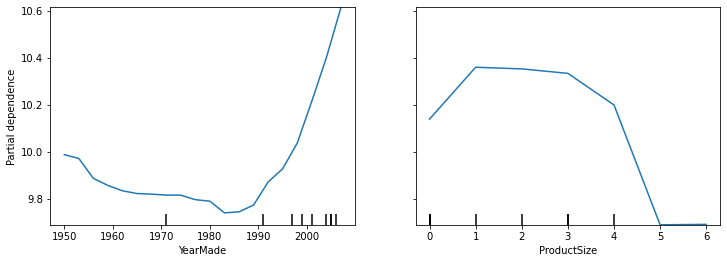

In [95]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Data Leakage

### Tree Interpreter

In [96]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [97]:
row = valid_xs_final.iloc[:5]

In [98]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [99]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94708073]), 10.104746057831763, -0.15766532528651994)

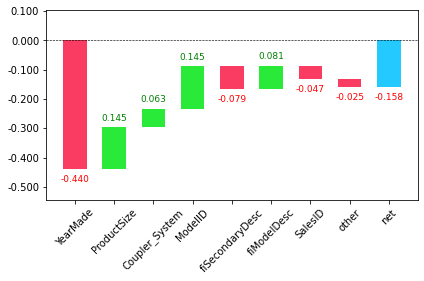

In [100]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation and Neural Networks

### The Extrapolation Problem

In [101]:
#hide
np.random.seed(42)

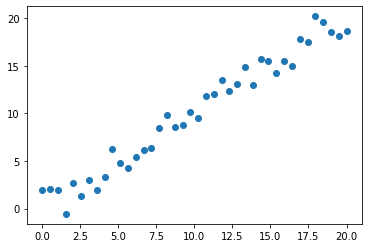

In [102]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [103]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [104]:
x_lin[:,None].shape

torch.Size([40, 1])

In [105]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

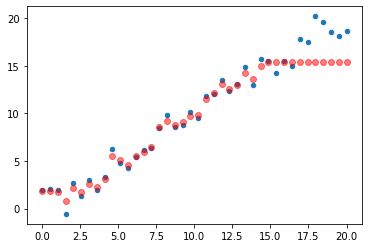

In [106]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

### Finding Out-of-Domain Data

In [107]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.858008
10,SalesID,0.098377
13,MachineID,0.035284
0,YearMade,0.002645
4,ModelID,0.001238
7,Enclosure,0.000891


In [108]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231847
SalesID 0.231492
saleElapsed 0.235826
MachineID 0.231672


In [109]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228826

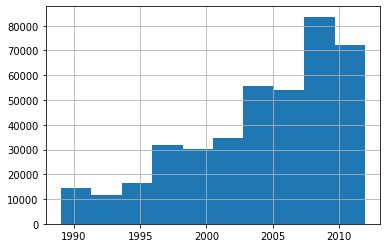

In [110]:
xs['saleYear'].hist();

In [111]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [112]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177757, 0.229866)

### Using a Neural Network

In [113]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [114]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [115]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [116]:
cont_nn

['saleElapsed']

In [129]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [120]:
xs_filt2 = xs_filt.drop('ModelID', axis=1)
valid_xs_time2 = valid_xs_time.drop('ModelID', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.17922, 0.232933)

In [128]:
xs_filt2 = xs_filt.drop(['fiModelDesc'], axis=1)
valid_xs_time2 = valid_xs_time.drop(['fiModelDesc'], axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.180558, 0.23281)

In [118]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176845, 0.229738)

In [ ]:
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.00015848931798245758)

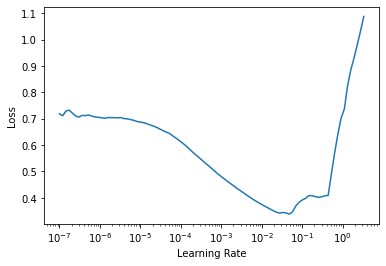

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063307,0.061940,01:03
1,0.054435,0.054207,00:57
2,0.047485,0.057621,01:03
3,0.043447,0.050539,00:57
4,0.040300,0.050236,01:03


In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.224134

In [ ]:
learn.save('nn')

Path('models/nn.pth')

### Sidebar: fastai's Tabular Classes

### End sidebar

## Ensembling

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
r_mse(ens_preds,valid_y)

0.221959

### Boosting

### Combining Embeddings with Other Methods

## Conclusion: Our Advice for Tabular Modeling

## Questionnaire

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide two of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kinds of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?
1. What is "out-of-bag-error"?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the "extrapolation problem"?
1. How can you tell if your test or validation set is distributed in a different way than your training set?
1. Why do we ensure `saleElapsed` is a continuous variable, even although it has less than 9,000 distinct values?
1. What is "boosting"?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

### Further Research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the dataset you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).